In [1]:
import pandas as pd
import numpy as np
import arviz as az
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv(r'C:\Users\rramr\OneDrive\Desktop\Modern Scientist Global\dataset\df_knn_for_bayesian.csv')

In [3]:
df.head()

,Unnamed: 0,age_m_r4,sexr1,Age_gap_r1,maternal_schooling_r1,no_of_household_members_r3,household_assets_index_r3,schooling_y_r5,score_waisiii_iq_zscore_r5,Height_adult,...,Stunting_Yes,Stunting_nan,type_of_employment_r5_Employee,type_of_employment_r5_Employer,type_of_employment_r5_Self-employed / Autonomous,type_of_employment_r5_Study / paid internship,type_of_employment_r5_nan,worked_and_paid_r5.1_No,worked_and_paid_r5.1_Yes,worked_and_paid_r5.1_nan
0,0,47,1.0,7,8.0,4.0,5.76350,13.0,1.510429,180.65,...,0,0,1,0,0,0,0,0,1,0
1,1,50,1.0,0,5.0,3.0,2.00260,16.0,0.399053,180.35,...,0,0,1,0,0,0,0,0,1,0
2,2,50,0.0,1,5.0,3.0,3.48310,15.0,0.002132,164.95,...,0,0,1,0,0,0,0,1,0,0
3,3,49,1.0,5,9.0,8.0,5.08150,4.0,-1.823701,182.30,...,0,0,0,0,0,0,1,1,0,0
4,4,43,1.0,8,15.0,4.2,4.88618,16.6,1.542183,173.66,...,0,1,0,0,0,0,1,0,0,1


In [4]:
from scipy import stats
import scipy.stats as stats

In [5]:
df2=df.copy()

In [6]:
Y=df2['Height_adult']

In [7]:
X=df2[['Height_adult','Stunting_Yes'
]]

In [8]:
from sklearn.model_selection import train_test_split
# df is features and labels are the targets 
# Split by putting 25% in the testing set
X_train, X_test,Y_train, Y_test = train_test_split(X,  Y,
                                                   test_size = 0.25,
                                                    random_state=42)

In [9]:
formula = 'Height_adult ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
formula

'Height_adult ~ Stunting_Yes'

In [18]:
import pymc3 as pm

# Context for the model
with pm.Model() as normal_model:
    
    my_priors= {
        'Intercept': pm.Normal.dist(mu=0., sigma=100.),
        'Height_adult': pm.Normal.dist(mu=1000, sigma=7.8)
        
    }
    
   
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = X_train, priors=my_priors)
    
    # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
    normal_trace = pm.sample(draws=3000, chains = 2, tune = 4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, Stunting_Yes, Intercept]


Sampling 2 chains for 4_000 tune and 3_000 draw iterations (8_000 + 6_000 draws total) took 25 seconds.


In [48]:
with pm.Model() as linear_model:
    # Intercept
    intercept = pm.Normal('Intercept', mu = 0, sd = 100)
    
    # Slope 
    slope = pm.Normal('slope', mu = 170, sd = 7.8)
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * X_train.loc[:, 'Stunting_Yes']
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = Y_train.values)
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace = pm.sample(2000, step)

C:\Users\rramr\Anaconda4\lib\site-packages\pymc3\sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope, Intercept]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


C:\Users\rramr\Anaconda4\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

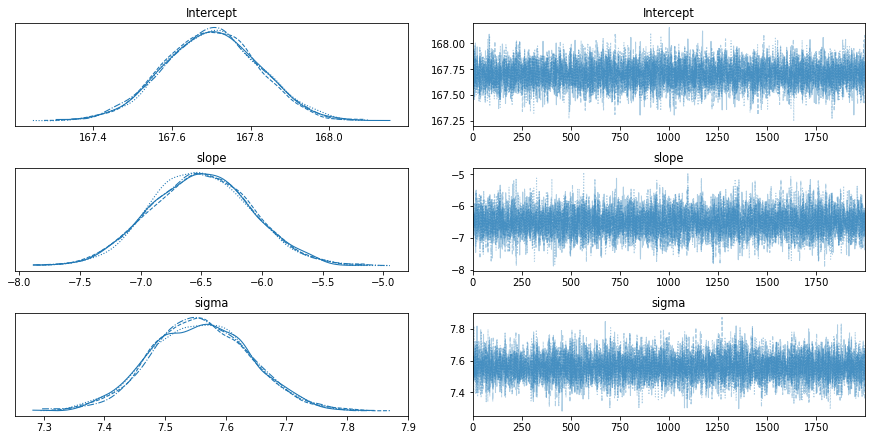

In [49]:
az.plot_trace(linear_trace)

In [20]:
import matplotlib.pyplot as plt
import matplotlib

In [21]:
# Shows the trace with a vertical line at the mean of the trace
def plot_trace(trace):
    # Traceplot with vertical lines at the mean value
    ax = az.plot_trace(trace, figsize=(14, len(trace.varnames)*1.8),
                      lines={k: v['mean'] for k, v in az.summary(trace).iterrows()})
    
    matplotlib.rcParams['font.size'] = 16
    
    # Labels with the median value
    for i, mn in enumerate(az.summary(trace)['mean']):
        ax[i, 0].annotate('{:0.2f}'.format(mn), xy = (mn, 0), xycoords = 'data', size = 8,
                          xytext = (-18, 18), textcoords = 'offset points', rotation = 90,
                          va = 'bottom', fontsize = 'large', color = 'red')

C:\Users\rramr\Anaconda4\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\rramr\Anaconda4\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\rramr\Anaconda4\lib\site-packages\arviz\plots\backends\matplotlib\traceplot.py:213: UserWarning: A valid var_name should be provided, found {'S', 's', 'I'} expected from {'Intercept', 'sd', 'Stunting_Yes'}
  warnings.warn(
C:\Users\rramr\Anaconda4\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` with

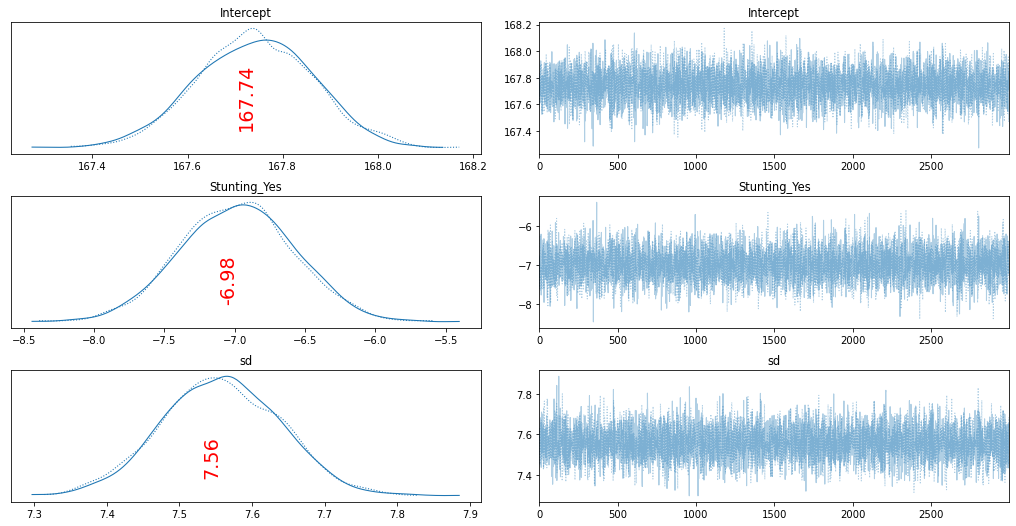

In [22]:
plot_trace(normal_trace);


In [50]:
az.summary(linear_trace)

C:\Users\rramr\Anaconda4\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,167.701,0.121,167.479,167.933,0.001,0.001,8888.0,8887.0,8885.0,5826.0,1.0
slope,-6.503,0.415,-7.308,-5.757,0.004,0.003,9875.0,9802.0,9843.0,5889.0,1.0
sigma,7.558,0.081,7.416,7.720,0.001,0.001,11325.0,11318.0,11321.0,5817.0,1.0


C:\Users\rramr\Anaconda4\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


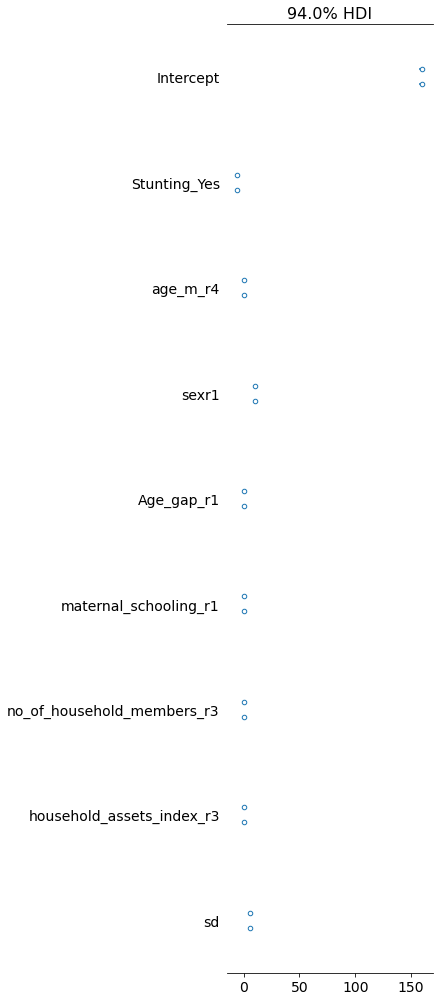

In [18]:
az.plot_forest(normal_trace);


## Trace Plot of All Samples

In [19]:

# Define a function to draw posterior plot
def posterior_plot (variable, xlabel):
    _, ax = plt.subplots(figsize = (12, 6))
    ax.hist([n.mean() for n in normal_trace[variable]], bins = 19, alpha = 0.5 , color = 'gray', edgecolor = 'black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set(title = 'Posterior predictive of ' + xlabel, xlabel = xlabel, ylabel = 'Frequency')

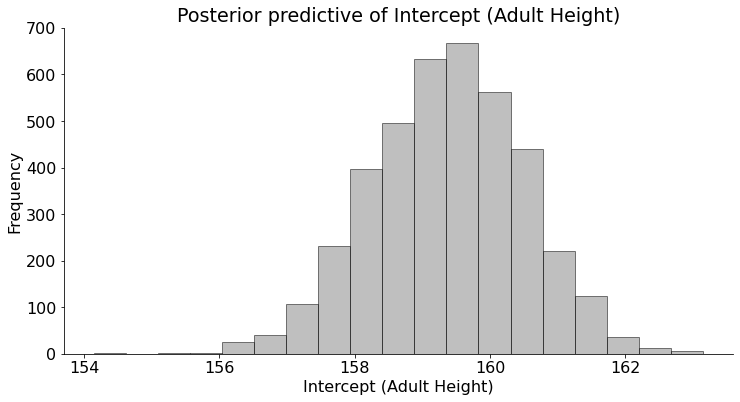

In [25]:
posterior_plot ('Intercept', 'Intercept (Adult Height)')

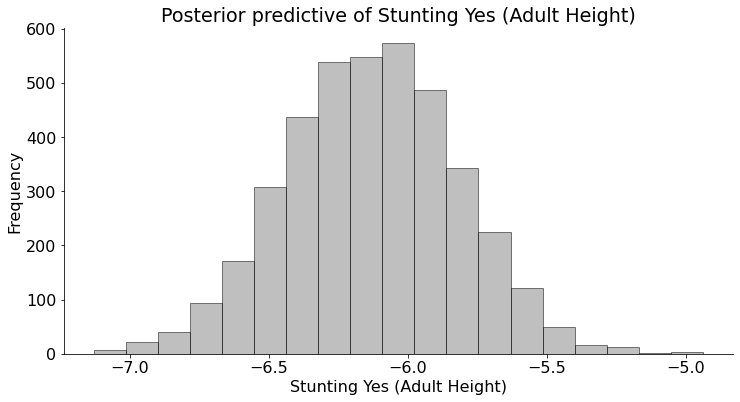

In [26]:
posterior_plot ('Stunting_Yes', 'Stunting Yes (Adult Height)')

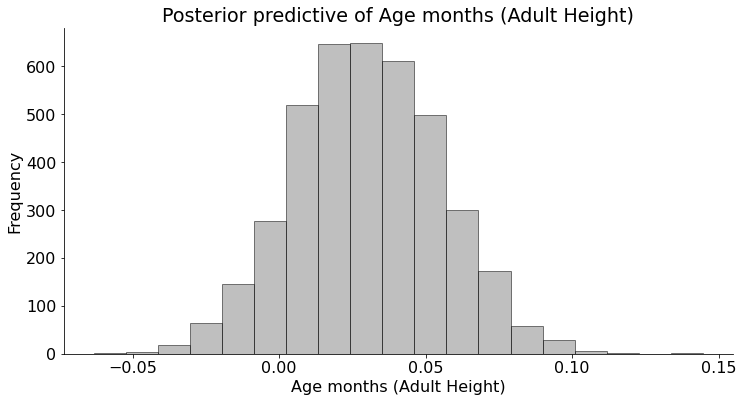

In [27]:
posterior_plot ('age_m_r4', 'Age months (Adult Height)')

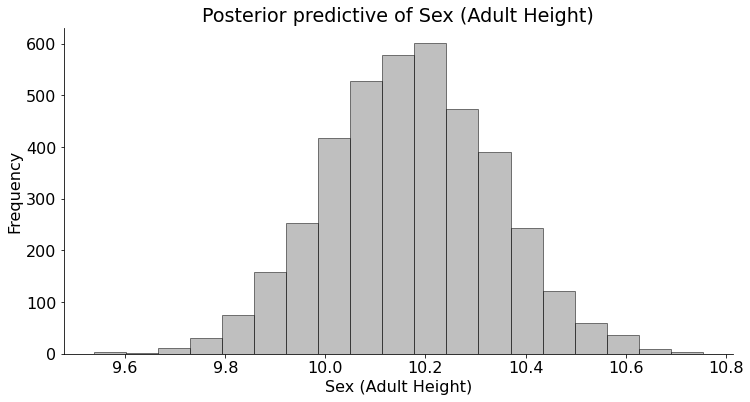

In [28]:
posterior_plot ('sexr1', 'Sex (Adult Height)')

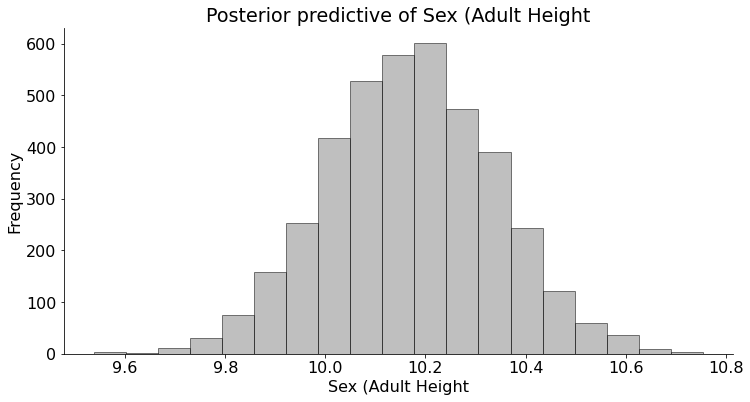

In [29]:
posterior_plot ('sexr1', 'Sex (Adult Height)')

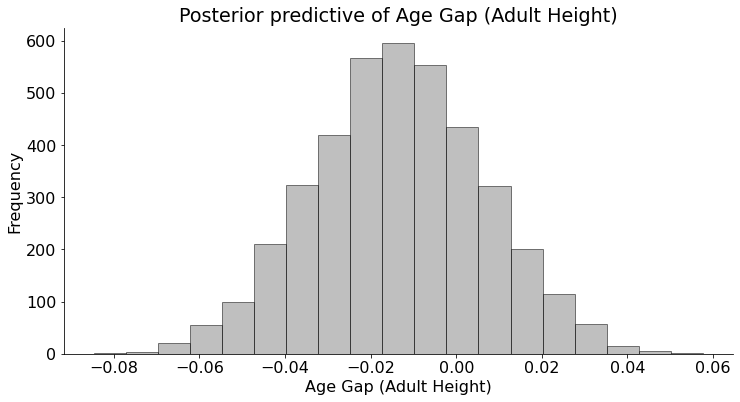

In [30]:
posterior_plot ('Age_gap_r1', 'Age Gap (Adult Height)')

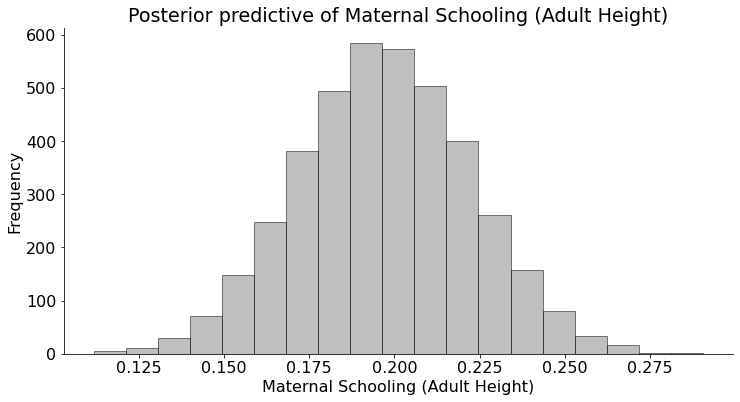

In [31]:
posterior_plot ('maternal_schooling_r1', 'Maternal Schooling (Adult Height)')

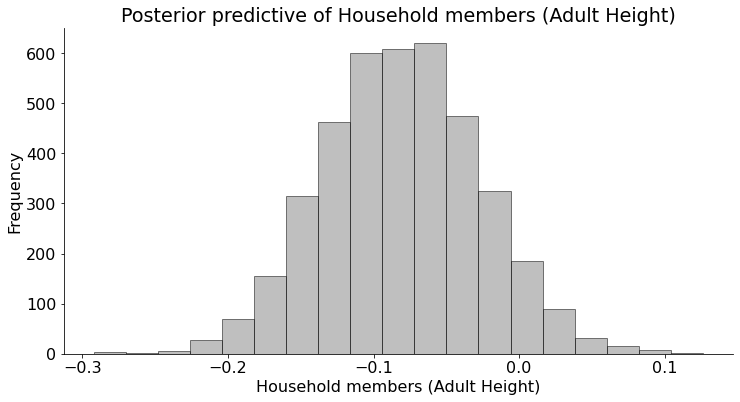

In [32]:
posterior_plot ('no_of_household_members_r3', 'Household members (Adult Height)')

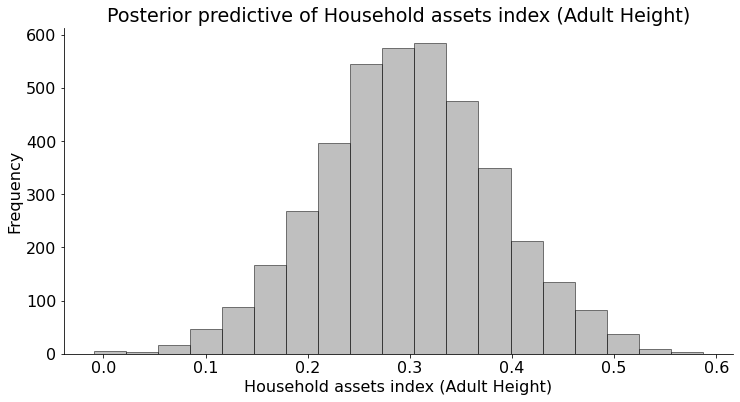

In [33]:
posterior_plot ('household_assets_index_r3', 'Household assets index (Adult Height)')

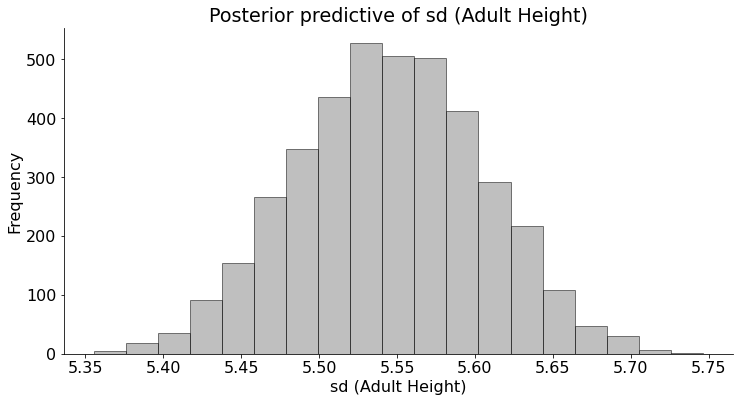

In [34]:
posterior_plot ('sd', 'sd (Adult Height)')

C:\Users\rramr\Anaconda4\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


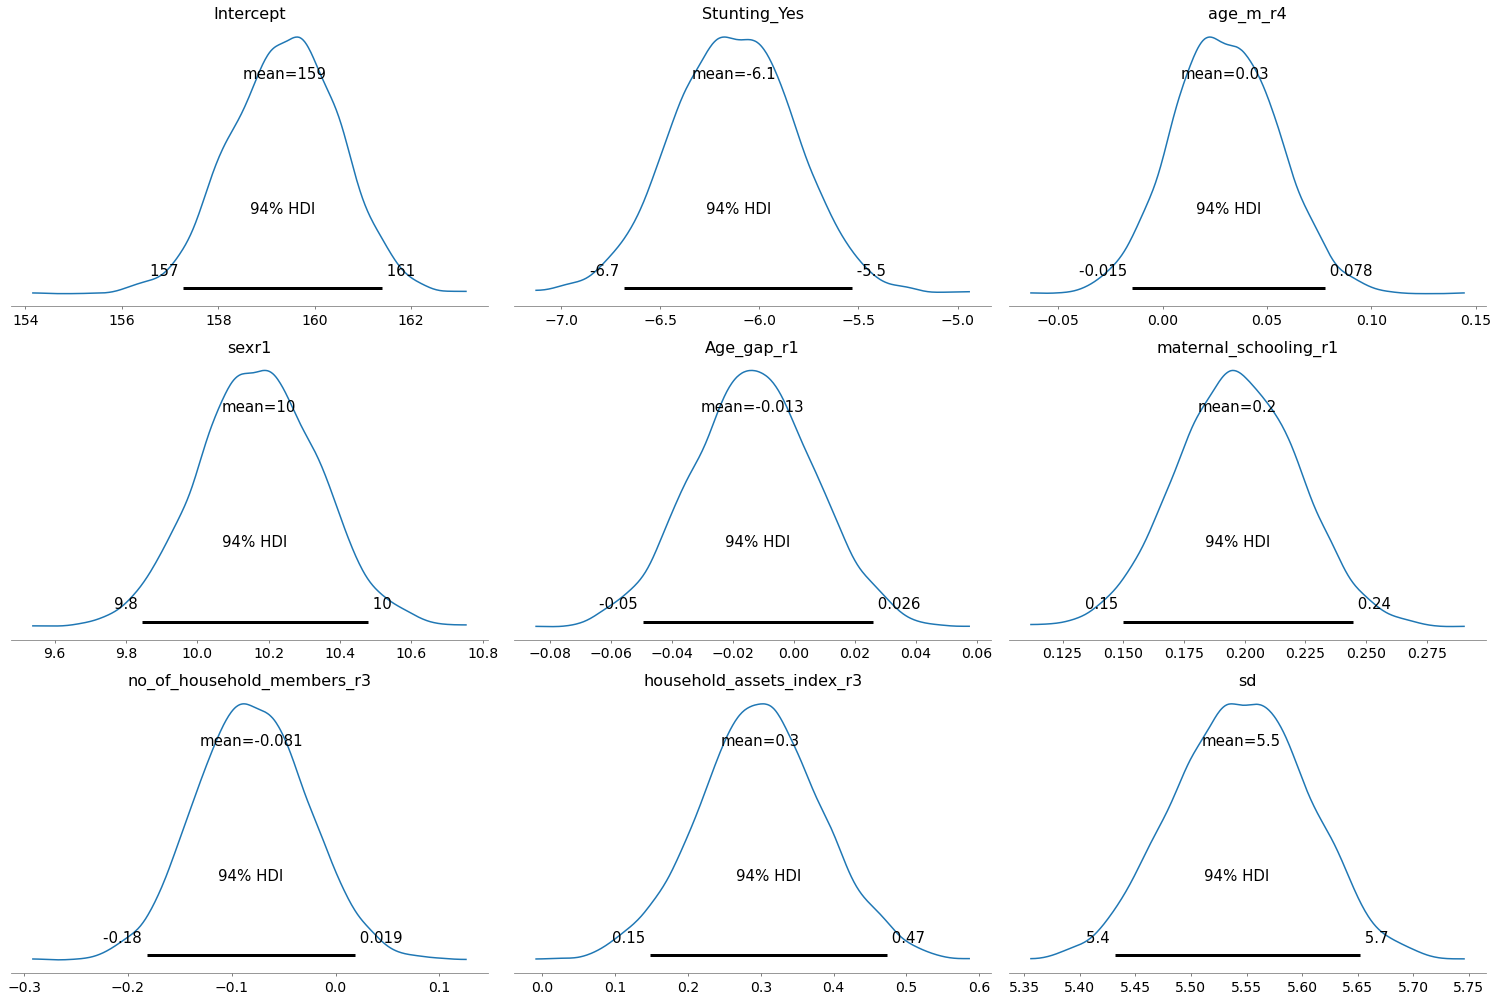

In [35]:
az.plot_posterior(normal_trace);

In [36]:
for variable in normal_trace.varnames:
    print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, 
                                                                np.mean(normal_trace[variable])))

Variable: Intercept       Mean weight in model: 159.3747
Variable: Stunting_Yes    Mean weight in model: -6.1291
Variable: age_m_r4        Mean weight in model: 0.0301
Variable: sexr1           Mean weight in model: 10.1709
Variable: Age_gap_r1      Mean weight in model: -0.0135
Variable: maternal_schooling_r1 Mean weight in model: 0.1970
Variable: no_of_household_members_r3 Mean weight in model: -0.0808
Variable: household_assets_index_r3 Mean weight in model: 0.2985
Variable: sd_log__        Mean weight in model: 1.7129
Variable: sd              Mean weight in model: 5.5453


In [38]:
# Examines the effect of changing a single variable
# Takes in the name of the variable, the trace, and the data
def model_effect(query_var, trace, X):
    
    # Variables that do not change
    steady_vars = list(X.columns)
    steady_vars.remove(query_var)
    
    # Linear Model that estimates a grade based on the value of the query variable 
    # and one sample from the trace
    def lm(value, sample):
        
        # Prediction is the estimate given a value of the query variable
        prediction = sample['Intercept'] + sample[query_var] * value
        
        # Each non-query variable is assumed to be at the median value
        for var in steady_vars:
            
            # Multiply the weight by the median value of the variable
            prediction += sample[var] * X[var].median()
        
        return prediction
    
    
    
    # Find the minimum and maximum values for the range of the query var
    var_min = X[query_var].min()
    var_max = X[query_var].max()
    
    # Plot the estimated grade versus the range of query variable
    pm.plot_posterior_predictive_glm(trace, eval=np.linspace(var_min, var_max, 100), 
                                     lm=lm, samples=100, color='blue', 
                                     alpha = 0.4, lw = 2)
    
    # Plot formatting
    plt.xlabel('%s' % query_var, size = 16)
    plt.ylabel('Cognition Z', size = 16)
    plt.title("Posterior of Adult Height  vs %s" % query_var, size = 18)
    plt.show()

# Model Variable Effects

 If we want to see the effect of changing one variable while holding the others constant, we can use the function pm.plot_posterior_predictive_glm. This takes a range of values to use for the variable, a linear model, and a number of samples. The function evaluates the linear model across the range of values for the number of samples. Each time, it draws a different set of parameters from the trace. This gives us an indication of the effect of a single variable and also the uncertainty in the model estimates. To see the effect of a single variable, we hold the others constant at their median values.

In [39]:
import matplotlib.pyplot as plt

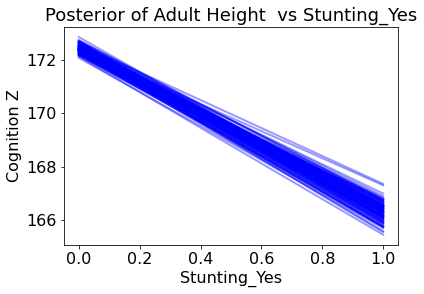

In [40]:
model_effect('Stunting_Yes', normal_trace, X_train.drop(columns='Height_adult'))


# trying other models 

In [51]:
# Calculate mae and rmse
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    r_squared = r2_score( true , predictions)
    
    
    return mae, rmse , r_squared

# Naive Baseline


In [52]:
median_pred = X_train['Height_adult'].median()
median_preds = [median_pred for _ in range(len(X_test))]
true = X_test['Height_adult']

In [53]:
mb_mae, mb_rmse , mb_r_squared = evaluate_predictions(median_preds, true)
print('Median Baseline  MAE: {:.4f}'.format(mb_mae))
print('Median Baseline RMSE: {:.4f}'.format(mb_rmse))
print('Median Baseline R squared: {:.4f}'.format(mb_r_squared))

Median Baseline  MAE: 6.2957
Median Baseline RMSE: 7.8426
Median Baseline R squared: -0.0052


# Standard Machine Learning Models

In [54]:
# Evaluate several ml models by training on training set and testing on testing set
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = [#'Linear Regression',
        'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    X_train = X_train.drop(columns='Height_adult')
    X_test = X_test.drop(columns='Height_adult')
    
    # Instantiate the models
    #model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse' , 'r_square'], index = model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([ model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        r_square = r2_score(y_test, predictions)
        
        
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse , r_square]
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    baseline_r_square = 0
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse , baseline_r_square]
    
    return results

In [55]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy

In [56]:
results = evaluate(X_train, X_test, Y_train, Y_test)

In [57]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(42)

 
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

import seaborn as sns

from IPython.core.pylabtools import figsize

# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats

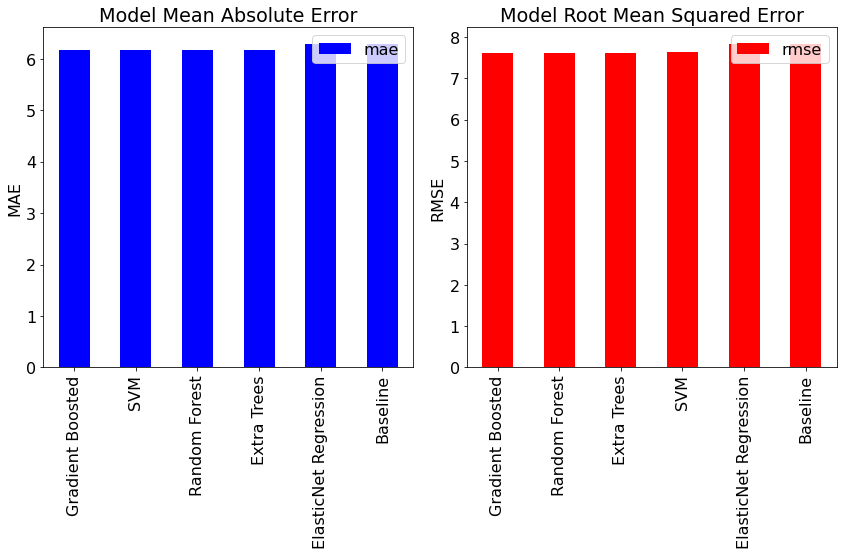

In [58]:
figsize(12, 8)
matplotlib.rcParams['font.size'] = 16
# Root mean squared error
ax =  plt.subplot(1, 2, 1)
results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'b', ax = ax)
plt.title('Model Mean Absolute Error'); plt.ylabel('MAE');

# Median absolute percentage error
ax = plt.subplot(1, 2, 2)
results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'r', ax = ax)
plt.title('Model Root Mean Squared Error'); plt.ylabel('RMSE');



plt.tight_layout()

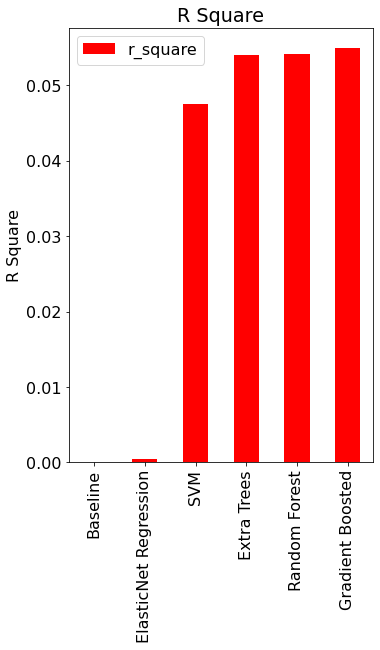

In [59]:
ax = plt.subplot(1, 2, 2)
results.sort_values('r_square', ascending = True).plot.bar(y = 'r_square', color = 'r', ax = ax)
plt.title('R Square'); plt.ylabel('R Square');

In [60]:
results

,mae,rmse,r_square
ElasticNet Regression,6.29492,7.82039,0.000484948
Random Forest,6.17756,7.60777,0.0540956
Extra Trees,6.1779,7.60805,0.0540255
SVM,6.16852,7.63428,0.0474912
Gradient Boosted,6.16525,7.60449,0.0549104
Baseline,6.29566,7.84262,0


# make predictions from model

# Test Observations

In [61]:
def test_model(trace, test_observation):
    
    # Print out the test observation data
    print('Test Observation:')
    print(test_observation)
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]

    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Standard deviation of the likelihood
    sd_value = var_weights['sd'].mean()

    # Actual Value
    actual = test_observation['Height_adult']
    
    # Add in intercept term
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop('Height_adult')
    
    # Align weights and test observation
    var_weights = var_weights[test_observation.index]

    # Means for all the weights
    var_means = var_weights.mean(axis=0)

    # Location of mean for observation
    mean_loc = np.dot(var_means, test_observation)
    
    # Estimates of grade
    estimates = np.random.normal(loc = mean_loc, scale = sd_value,
                                 size = 1000)

    # Plot all the estimates
    plt.figure(figsize(8, 8))
    sns.distplot(estimates, hist = True, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 4},
                label = 'Estimated Dist.')
    # Plot the actual grade
    plt.vlines(x = actual, ymin = 0, ymax = 0.1, 
               linestyles = '--', colors = 'red',
               label = 'True Height',
              linewidth = 2.5)
    
    # Plot the mean estimate
    plt.vlines(x = mean_loc, ymin = 0, ymax = 0.1, 
               linestyles = '-', colors = 'orange',
               label = 'Mean Estimate',
              linewidth = 2.5)
    
    plt.legend(loc = 1)
    plt.title('Density Plot for Test Observation');
    plt.xlabel('Height'); plt.ylabel('Density');
    
    # Prediction information
    print('True Height = %d' % actual)
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

Test Observation:
Height_adult                  162.800000
Stunting_Yes                    0.000000
age_m_r4                       45.008170
sexr1                           0.000000
Age_gap_r1                      3.501596
maternal_schooling_r1           8.000000
no_of_household_members_r3      5.000000
household_assets_index_r3       3.197900
Name: 705, dtype: float64
True Height = 162
Average Estimate = 162.8086
5% Estimate = 153.6170    95% Estimate = 172.0361


C:\Users\rramr\Anaconda4\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


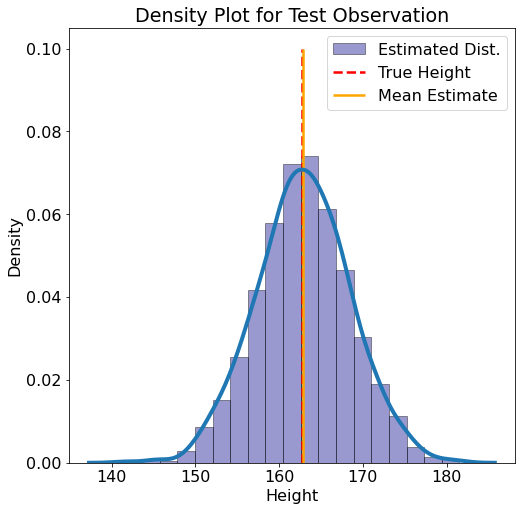

In [67]:
test_model(normal_trace, X_test.iloc[5])



# Linear Formula from Bayesian Inference using Mean of Parameters¶

In [77]:
model_formula = 'score_waisiii_iq_zscore_r5 = '
for variable in normal_trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(normal_trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

'score_waisiii_iq_zscore_r5 =  -2.11 * Intercept + -0.24 * Stunting_Yes + 0.03 * age_m_r4 + 0.08 * sexr1 + 0.00 * Age_gap_r1 + 0.08 * maternal_schooling_r1 + -0.07 * no_of_household_members_r3 + 0.19 * household_assets_index_r3 + -0.35 * sd_log__ + 0.70 * sd'

# Evaluate Bayesian Model Using Mean of Model Parameters

In [78]:
# Evalute the MCMC trace and compare to ml models
def evaluate_trace(trace, X_train, X_test, y_train, y_test, model_results):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
    
    # Create an intercept column
    #X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns[1:]
    X_test = X_test.loc[:, names]
    var_means = var_means[names]
    
    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.loc[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
        
    # Metrics 
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    mae = np.mean(abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))
    
    print('Model  MAE: {:.4f}\nModel RMSE: {:.4f}'.format(mae, rmse))
    
    # Add the results to the comparison dataframe
    model_results.loc['Bayesian LR', :] = [mae, rmse]
    
    plt.figure(figsize=(12, 8))
    
    # Plot median absolute percentage error of all models
    ax = plt.subplot(1, 2, 1)
    model_results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'r', ax = ax)
    plt.title('Model Mean Absolute Error Comparison'); plt.ylabel('MAE'); 
    plt.tight_layout()
    
    # Plot root mean squared error of all models
    ax = plt.subplot(1, 2, 2)
    model_results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'b', ax = ax)
    plt.title('Model RMSE Comparison'); plt.ylabel('RMSE')
    
    return model_results

In [79]:
all_model_results = evaluate_trace(normal_trace, X_train, X_test, Y_train, Y_test, results)


Model  MAE: 2.0874
Model RMSE: 2.2074


ValueError: cannot copy sequence with size 2 to array axis with dimension 3

In [79]:
all_model_results


,mae,rmse
Linear Regression,0.440216,0.66787
ElasticNet Regression,0.524602,0.724584
Random Forest,0.46974,0.679982
Extra Trees,0.491373,0.702504
SVM,0.495098,0.70634
Gradient Boosted,0.46013,0.675196
Baseline,0.645391,0.836447
Bayesian LR,0.440183,0.667845
